In [212]:
import json
import pandas as pd
from pathlib import Path
from brokenaxes import brokenaxes
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

# plotting config
textwidth_pt = 395.8225
table_cell_width_pt = textwidth_pt/8

In [213]:
# For linux...
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{underscore}'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.rcfonts'] = False

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # ACM uses Linux Libertine as the main font
    #"text.latex.preamble": r"\usepackage{libertine}",
    # Use 9pt font in plots to match ACM style
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts slightly smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
plt.rcParams.update(tex_fonts)
sns.set_palette("deep")

In [214]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def read_csv_dataset(dataset_path):
    """
    This method reads a dataset from a csv file path.
    """
    dataframe = pd.read_csv(dataset_path, sep=",", header="infer", encoding="utf-8", dtype=str,
                                keep_default_na=False, low_memory=False)
    return dataframe

In [215]:
def get_measurements(measurements_dir: str = 'measurements/'):
    measurements = []
    pathlist = Path(measurements_dir).glob('*.json')
    
    for path in pathlist:
        with open(path) as f:
            res = json.load(f)
            run, dataset = path.name.split('.')[0].split('-')
            res = {'run': run, 'dataset': dataset, **res}
            measurements.append(res)
    
    print(f'{len(measurements)} measurements loaded.')
    return measurements

In [216]:
results = get_measurements('measurements/20241031-hospital-replica/')
df = pd.DataFrame(results)

50 measurements loaded.


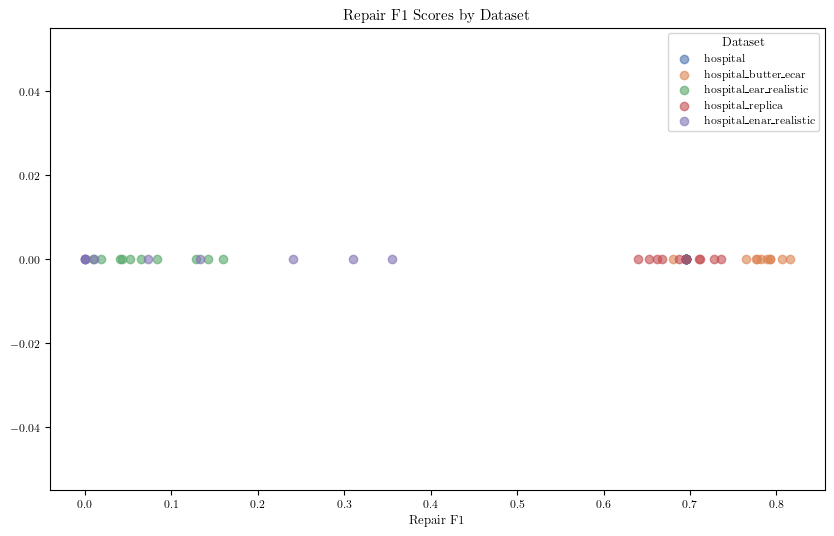

In [217]:
plt.figure(figsize=(10, 6))

# Use unique dataset values to loop and plot each with a different color
for dataset_name in df['dataset'].unique():
    subset = df[df['dataset'] == dataset_name]
    plt.scatter(subset['repair_f1'], [0] * len(subset), label=dataset_name, alpha=0.6)

# Add labels and title
plt.xlabel('Repair F1')
plt.title('Repair F1 Scores by Dataset')
plt.legend(title='Dataset')

# Show plot
plt.show()

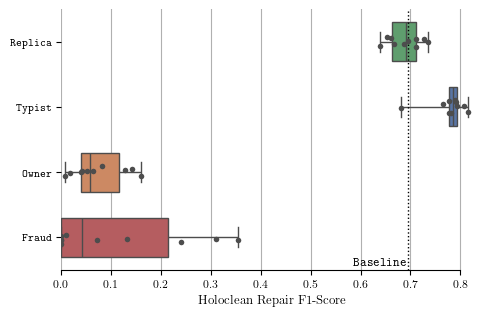

In [218]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe and relabel the datasets with LaTeX-style formatting
df_sub = df[df['dataset'].isin(['hospital_replica', 'hospital_butter_ecar', 'hospital_ear_realistic', 'hospital_enar_realistic'])]
df_sub.loc[:, 'dataset'] = df_sub['dataset'].replace(
    ['hospital_butter_ecar', 'hospital_replica', 'hospital_ear_realistic', 'hospital_enar_realistic'],
    [r'\texttt{Typist}', r'\texttt{Replica}', r'\texttt{Owner}', r'\texttt{Fraud}']
)

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=set_size(textwidth_pt))
ax.set_xlim(0, .85)

# Plot the orbital period with horizontal boxes
sns.boxplot(
    df_sub, 
    x="repair_f1", 
    y="dataset", 
    hue="dataset",
    whis=[0, 100], 
    width=.6, 
    order=[r'\texttt{Replica}', r'\texttt{Typist}', r'\texttt{Owner}', r'\texttt{Fraud}']
)

# Add in points to show each observation
sns.stripplot(df_sub, x="repair_f1", y="dataset", size=4, color=".3")

# Add reference to hospital baseline
hosp_baseline = df[df['dataset'] == 'hospital'].repair_f1.iloc[0]
ax.axvline(x=hosp_baseline, color='black', linestyle=':', linewidth=1)
ax.text(hosp_baseline - 0.005, (1-0.06)*ax.get_ylim()[0], r'\texttt{Baseline}', color='black', 
        ha='right', va='top', rotation=0, fontsize=9, fontweight='bold')

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="Holoclean Repair F1-Score")
sns.despine(trim=True, left=True)
plt.savefig("img/2025-08-18-hosp-error-scenarios.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Error-Histograms

In [219]:
mechanisms = ['ECAR', 'EAR', 'ENAR']
#default_palette = sns.color_palette()  # This gives the default Seaborn palette
#palette_dict = {'ECAR': default_palette[0], 'EAR': default_palette[1], 'ENAR': default_palette[5]}
# But we want consistency with the diagrams... Initiating alteration.
palette_dict = {
    "ENAR": "#fff2cc",
    "ECAR": "#9673A6",
    "EAR": "#6C8EBF",
}



### Original

In [220]:
df_clean_str = read_csv_dataset('../data/hospital/clean.csv').astype(str)
df_dirty_str = read_csv_dataset('../data/hospital/dirty.csv').astype(str)
df_clean_str = df_clean_str.rename(columns={'StateAverage': 'Stateavg'})
df_dirty_str = df_dirty_str.rename(columns={'StateAverage': 'Stateavg'})
df_clean_str = df_clean_str.drop('index', axis=1)
df_dirty_str = df_dirty_str.drop('index', axis=1)

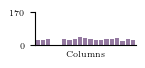

In [221]:
se_errors = (df_clean_str != df_dirty_str).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 'ECAR'
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
plt.savefig("img/2025-08-18-hosp-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

### EAR Realistic

In [222]:
df_realistic_clean = read_csv_dataset('../export_data/hospital/hospital_ear_realistic_clean.csv')
df_realistic_dirty = read_csv_dataset('../export_data/hospital/hospital_ear_realistic_0.csv')

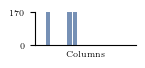

In [223]:
se_errors = (df_realistic_clean != df_realistic_dirty).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 'EAR'
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
plt.savefig("img/2025-08-18-hosp-realistic-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## ENAR Realistic

In [224]:
df_enar_realistic_clean = read_csv_dataset('../export_data/hospital/hospital_enar_realistic_clean.csv')
df_enar_realistic_dirty = read_csv_dataset('../export_data/hospital/hospital_enar_realistic_0.csv')

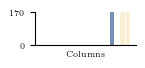

In [225]:
se_errors = (df_enar_realistic_clean != df_enar_realistic_dirty).sum()
df_errors = se_errors.to_frame().reset_index()
df_errors.columns = ['column', 'errors']
df_errors['mechanism'] = 16*['EAR'] + 3*['ENAR']
f, ax = plt.subplots(figsize=(1.3, 0.43))
sns.barplot(data=df_errors, x='column', y='errors', hue='mechanism', palette=palette_dict, ax=ax, legend=False)
sns.despine()
plt.ylim(0, 170)
plt.ylabel('')
plt.xlabel('Columns', fontsize=6)
plt.yticks([0, 170], fontsize=6)
plt.xticks([])
plt.savefig("img/2025-08-18-hosp-enar-realistic-error-histogram.pdf", format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

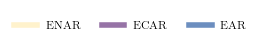

In [226]:
# Create a figure and axis with no data
fig, ax = plt.subplots(figsize=(1.3, 0.43))

# Create legend handles manually
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in palette_dict.values()]

# Add the legend to the figure
legend = ax.legend(handles, list(palette_dict.keys()), loc="center", frameon=False, ncol=len(palette_dict))

# Remove axis from the figure to leave only the legend
ax.axis("off")

# Adjust figure size so it fits the legend only
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("img/2025-08-18-legend-histogram.pdf", bbox_inches=bbox, format="pdf")
plt.show()

## 2025-05-18 Impact Measurments

In [227]:
def get_impact_measurements(measurements_dir: str, algorithm_name: str):
    measurements = []
    pathlist = Path(measurements_dir).glob('*.json')
    
    for path in pathlist:
        with open(path) as f:
            res = json.load(f)
            if algorithm_name == 'Baran':
                res = res[0]
            if algorithm_name == 'Renuver':
                res['f1'] = res['ec_f']
                res['precision'] = res['ec_p']
                res['recall'] = res['ec_r']
            if algorithm_name == 'Holoclean':
                parts = path.name.split('_')
                dataset_name = parts[1]
                version = parts[-2]
                if 'scenario' in parts:
                    scenario = 'scenario'
                elif 'ecar' in parts:
                    scenario = 'missing_ecar'
                elif 'original' in parts:
                    scenario = 'original'
                else:
                    raise ValueError('no scenario present')
                res['dataset_name'] = dataset_name
                res['scenario'] = scenario
                res['version'] = version
                res['f1'] = res['repair_f1']
                res['precision'] = res['precision']
                res['recall'] = res['repair_recall']
            res['version'] = res['version'] if res['scenario'] != 'original' else ''
            res = {'algorithm': algorithm_name, **res}
            measurements.append(res)
    
    print(f'{len(measurements)} measurements loaded.')
    return measurements

147 measurements loaded.
65 measurements loaded.
116 measurements loaded.


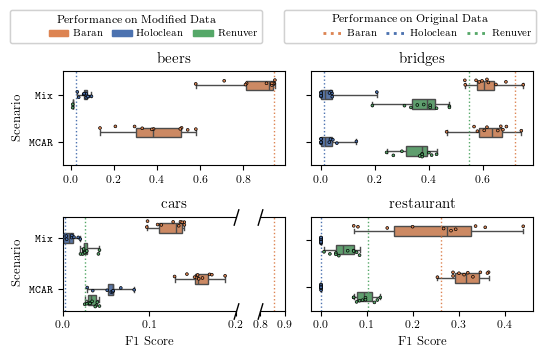

In [228]:
# Load data
res_baran = get_impact_measurements('measurements/20250518-cleaning-impact/baran-correction-results/', 'Baran')
res_renuver = get_impact_measurements('measurements/20250518-cleaning-impact/renuver-results/', 'Renuver')
res_hc = get_impact_measurements('measurements/20250518-cleaning-impact/holoclean-results/', 'Holoclean')
df = pd.DataFrame([*res_baran, *res_hc, *res_renuver]).loc[:, ['algorithm', 'dataset_name', 'scenario', 'version', 'precision', 'recall', 'f1']]

df_complete = df[df['dataset_name'].isin(['bridges', 'beers', 'cars', 'restaurant'])]
df_hc = df[df['dataset_name'].isin(['flights', 'rayyan', 'beers', 'food'])]

# Set figure size
fig = plt.figure(figsize=set_size(textwidth_pt))
sps = gridspec.GridSpec(2,2)

# Filter the dataframe and relabel the datasets with LaTeX-style formatting
df_complete.loc[:, 'scenario'] = df_complete.loc[:, 'scenario'].replace(
    ['scenario', 'missing_ecar', 'original'],
    [r'\texttt{Mix}', r'\texttt{MCAR}', 'original']
)

# Plot each dataset
dataset_names = ['beers', 'bridges', 'cars', 'restaurant']

# Define a consistent palette for algorithms if you want to ensure colors are the same across plots
# This makes sure the same algorithm gets the same color everywhere
algorithms_order = sorted(df_complete['algorithm'].unique())
palette = sns.color_palette("deep", n_colors=len(algorithms_order))
algorithm_color_map = dict(zip(algorithms_order, palette))
temp_color = algorithm_color_map['Baran']
algorithm_color_map['Baran'] = algorithm_color_map['Holoclean']
algorithm_color_map['Holoclean'] = temp_color

axes = []

for sp, ds in zip(sps, dataset_names):
    # select relevant dataset
    df_sub = df_complete[df_complete['dataset_name'] == ds]
    # exclude original scenario
    df_sub = df_sub[df_sub['scenario'] != 'original']

    if ds == 'cars':
        gs_cars = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=sp, width_ratios=[7, 1], wspace=0.25)
        ax = fig.add_subplot(gs_cars[0])
        ax2 = fig.add_subplot(gs_cars[1])
        ax.set_xlim(0, 0.2)
        ax2.set_xlim(0.8, 0.9)
        # hide the spines between ax and ax2
        ax.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)
        #ax.xaxis.tick_top()
        ax.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.xaxis.tick_bottom()
    else:
        ax = fig.add_subplot(sp)

    axes.append(ax)

    sns.boxplot(
        df_sub, 
        x="f1", 
        y="scenario", 
        hue="algorithm",
        ax=ax,
        whis=[0, 100],
        width=.6,
        order=[r'\texttt{Mix}', r'\texttt{MCAR}'],
        palette=algorithm_color_map
    )
    if ds != 'cars':
        ax.set_title(ds)
    ax.set_ylabel("Scenario")
    ax.set_xlabel("F1 Score")

    if ds == 'cars':  # plot data twice
        sns.boxplot(
            df_sub, 
            x="f1", 
            y="scenario", 
            hue="algorithm",
            ax=ax2,
            whis=[0, 100],
            width=.6,
            order=[r'\texttt{Mix}', r'\texttt{MCAR}'],
            palette=algorithm_color_map
        )
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax2.set_xlabel("")

        # ghost-axes for centering the title
        ax_ghost = fig.add_subplot(gs_cars[:])
        ax_ghost.axis('off')
        ax_ghost.set_title(ds)
        ax_ghost.set_xlabel("F1 Score")

        # set ticks on x-axis to be coherent
        ax.set_xticks([0.0, 0.1, 0.2])

    # plot points
    sns.stripplot(
        df_sub,
        x="f1",
        y="scenario",
        hue="algorithm",
        ax=ax,
        palette=algorithm_color_map,
        size=2,
        dodge=True, # don't overlap points
        jitter=0.2,
        legend=False,
        linewidth=0.5, # Add a thin outline
        edgecolor='black' # Outline color to make points stand out
    )

    original_df_ds = df_complete[
        (df_complete['dataset_name'] == ds) &
        (df_complete['scenario'] == 'original')
    ]

    for algo in algorithms_order: # Iterate through algorithms in the defined order
        original_algo_data = original_df_ds[original_df_ds['algorithm'] == algo]
        if not original_algo_data.empty: # Check if original data exists for this algorithm
            original_f1 = original_algo_data.f1.iloc[0]
            color = algorithm_color_map[algo] # Get the color from the consistent map
            if ds == 'cars' and algo == 'Baran':
                ax2.axvline(x=original_f1, color=color, linestyle=':', linewidth=1)
            else:
                ax.axvline(x=original_f1, color=color, linestyle=':', linewidth=1)
    
    if ds == 'cars':
        d = .3  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax.plot([1, 1], [0, 1], transform=ax.transAxes, **kwargs)
        ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

# --- START: Legend handling ---

# --- Legend 1: Performance on Modified Data (Solid Boxes) ---
legend1_handles = []
legend1_labels = []

for algo in algorithms_order:
    color = algorithm_color_map[algo]
    legend1_handles.append(mpatches.Patch(color=color, label=f' {algo}'))
    legend1_labels.append(f' {algo}') # Label for the algorithm

# Add the title as a separate handle/label for the first legend
legend1_title_handle = mpatches.Patch(color='none', label='Performance on Modified Data')
legend1_title_label = '' # Empty label for the title handle

# Prepend the title to handles and labels
legend1_handles.insert(0, legend1_title_handle)
legend1_labels.insert(0, legend1_title_label)

# Create the first legend
legend1 = fig.legend(
    title='Performance on Modified Data',
    title_fontsize=8,
    handles=legend1_handles,
    labels=legend1_labels,
    loc='upper center', # Adjust as needed
    bbox_to_anchor=(0.25, 1.05), # Position for the left legend
    ncol=len(algorithms_order) + 1, # +1 for the title
    frameon=True,
    fontsize=7,
    borderpad=0.5, # Padding within the legend box
    labelspacing=0.5, # Vertical spacing between handles
    handletextpad=0.5, # Padding between handle and text
    columnspacing=1.0 # Spacing between columns
)
# Manually set the title's font size if needed (e.g., if you want it larger than other labels)
# Find the text object for the title within the legend
for text_obj in legend1.get_texts():
    if text_obj.get_text() == 'Performance on Modified Data':
        text_obj.set_fontsize(8) # Or adjust as desired
        text_obj.set_weight('bold') # Make it bold if desired

# --- Legend 2: Performance on Original Data (Dashed Lines) ---
legend2_handles = []
legend2_labels = []

for algo in algorithms_order:
    color = algorithm_color_map[algo]
    legend2_handles.append(mlines.Line2D([0], [0], color=color, linestyle=':', linewidth=2, label=f' {algo}'))
    legend2_labels.append(f' {algo}') # Label for the algorithm

# Add the title for the second legend
legend2_title_handle = mpatches.Patch(color='none', label='Performance on Original Data')
legend2_title_label = '' # Empty label for the title handle

# Prepend the title to handles and labels
legend2_handles.insert(0, legend2_title_handle)
legend2_labels.insert(0, legend2_title_label)

# Create the second legend
legend2 = fig.legend(
    title="Performance on Original Data",
    title_fontsize=8,
    handles=legend2_handles,
    labels=legend2_labels,
    loc='upper center', # Adjust as needed
    bbox_to_anchor=(0.75, 1.05), # Position for the right legend
    ncol=len(algorithms_order) + 1, # +1 for the title
    frameon=True,
    fontsize=7,
    borderpad=0.5,
    labelspacing=0.5,
    handletextpad=0.5,
    columnspacing=1.0
)

# Manually set the title's font size if needed
for text_obj in legend2.get_texts():
    if text_obj.get_text() == 'Performance on Original Data':
        text_obj.set_fontsize(8) # Or adjust as desired
        text_obj.set_weight('bold') # Make it bold if desired


fig.add_artist(legend1)
fig.add_artist(legend2)

# Remove the default legends from the subplots as before
for ax in axes:
    if ax.legend_ is not None:
        ax.legend_.remove()
ax2.legend_.remove()

# --- END: Legend handling ---

for i, ax in enumerate(axes[:]):
    if i % 2 == 1:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    if i < 2:
        ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust top value as needed to fit legends
fig.savefig("img/2025-05-25-cleaning-impact-complete.pdf", bbox_inches='tight', format="pdf")
plt.show()

ML downstream plot

    Unnamed: 0                error_type  dataset_id  error_rate mechanism  \
30         150  clf-wrongunit-extraneous       44162        0.25      ECAR   
31         151  clf-wrongunit-extraneous       44162        0.25       EAR   
32         152  clf-wrongunit-extraneous       44162        0.25      ENAR   
33         153  clf-wrongunit-extraneous       44162        0.25      ECAR   
34         154  clf-wrongunit-extraneous       44162        0.25       EAR   

      metric     score  actual_error_rate  
30  f1_score  0.899099               0.25  
31  f1_score  0.842042               0.25  
32  f1_score  0.999399               0.25  
33  f1_score  0.889489               0.25  
34  f1_score  0.906306               0.25  


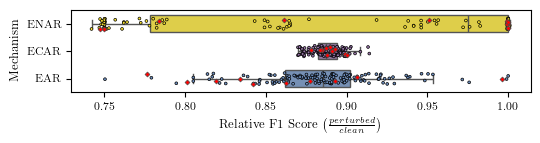

In [229]:
colors = {
    "ENAR": "#f7e131",
    "ECAR": "#9673A6",
    "EAR": "#6C8EBF",
}

# Read in the data - clf wrongunit extraneous, 0.25
df_sub = pd.read_csv("measurements/20250813-ml-downstream-results/ml-downstream-data.csv")

# --- Figure size matching LaTeX ---
fig_width = textwidth_pt / 72.27  # inches, typical LaTeX text width
fig_height = 1.5  # ~1/6 page height

g = sns.catplot(
    data=df_sub,
    x="score",
    y="mechanism",
    hue="mechanism",
    col="error_rate",
    kind="box",
    width=0.6,
    order=["ENAR", "ECAR", "EAR"],
    palette=colors,
    sharex=True,
    sharey=True,
    height=fig_height,
    aspect=fig_width/fig_height,
    showfliers=False
)



g.set_titles("")

# --- Overlay stripplots per facet ---
for ax, (_, subdata) in zip(g.axes.flat, df_sub.groupby("error_rate")):
    # Set all four spines to black
    ax.set_frame_on(True)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.8)

    sns.stripplot(
        data=subdata[subdata['dataset_id'] != 44162],
        x="score",
        y="mechanism",
        hue="mechanism",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        jitter=0.2,
        size=2,
        palette=colors,
        linewidth=0.5,
        edgecolor='black'
    )
    sns.stripplot(
        data=subdata[subdata['dataset_id'] == 44162],
        x="score",
        y="mechanism",
        order=["ENAR", "ECAR", "EAR"],
        ax=ax,
        jitter=0.2,
        size=2.5,
        color='red',
        linewidth=0.5,
        marker='D'

    )
    print(subdata[subdata['dataset_id'] == 44162].head())
    # Keep y-labels
    ax.set_ylabel("Mechanism")
    ax.set_xlabel(r"Relative F1 Score $\left(\frac{perturbed}{clean}\right)$")

plt.tight_layout()
plt.show()

# Saving
fig = g.figure

# Set PDF metadata
metadata = {
    'Title': 'ML Downstream Results',
    'Author': 'Nicholas Chandler',
    'Subject': 'Error measurement visualization',
    'Keywords': 'ML, error, ECAR, EAR, ENAR',
    'Creator': 'Matplotlib',
    'Producer': 'pdfTeX/Matplotlib',
}

# Save as PDF
fig.savefig(
    "img/2025-08-13-downstream-ml.pdf",
    dpi=300,             # resolution for rasterized elements
    bbox_inches='tight', # tight layout
    metadata=metadata,
)
